# Classificaion of Two circle of points

**Learning Source:**

freeCodeCamp.org : PyTorch for Deep Learning & Machine Learning – Full Course 

This example is a example of implementation of classification example from the provided tutorial. This example is a **non linear regression binary classification** problem. In this example we will see a linear approach to try and solve the problem, see it's limitation and then introduce the non linearity **ReLU** function to better fit the classification example.

**References:**
- Link to resource: https://www.youtube.com/watch?v=V_xro1bcAuA
- https://pytorch.org/tutorials/beginner/ptcheat.html
- https://www.geeksforgeeks.org/regression-in-machine-learning/
- https://www.geeksforgeeks.org/non-linear-regression-examples-ml/

## 01. Setup Environment

### 01.01 Setting up environment

In [ ]:
# install basic packages required for the project
%conda install numpy pandas matplotlib
%conda install pytorch -c pytorch
%conda install scikit-learn
%conda install tqdm

### 01.02 Importing Libraries to python

In [248]:
import torch

torch.__version__

'2.5.1'

### 01.03 Setting up Device Agnostic code and device selection

In [249]:
#setup devices agnostic code
print("Setting up device agnostic ...")
if torch.cuda.is_available():       # Check if cuda available
    device = torch.device("cuda")   # Set device as cuda
elif torch.mps.is_available():      # Check if mps available
    device = torch.device("mps")    # Set device as mps
else:                               # Default device selection
    device = torch.device("cpu")    # Set device as cpu, Default behavour

print(f"Selected device for processing : {device}")

Setting up device agnostic ...
Selected device for processing : mps


### 01.04 Setting up some Helper Functions

In [250]:
import torch
import matplotlib.pyplot as plt
import numpy as np



def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


## 02. Data Preparation and Loading

### 02.01 Preparing (Generating) data

Let up begin by utilizing the sklearn library's `make.circle()` method to generate two sets of circularly distributed data points

In [251]:
from sklearn.datasets import make_circles

#define the size of the samples
sample_size = 1000
sample_noise = 0.03

# Make a dataset with a small circle inside a large circle
X_arr, y_arr = make_circles(n_samples=sample_size,
                    noise=sample_noise,                     # Add some noise to the sample so it is not perfect circle
                    random_state=42)                        # Set the random seed for reproducibility

X_arr.shape, y_arr.shape

((1000, 2), (1000,))

As you can see we get the x,y co-ordinate feature data in the X and 0,1 label to distinguish the point between the two circle category in y.

Now that we have a set of samples and features. Let us visualize the data. For this purpose we will use pandas to convert the tuple data we get from sklearn to a pandas dataframe. This dataframe then can be used to visualize using the **scatter plot** functionality provided from matplotlib

In [252]:
import pandas as pd

# Convert the data into a pandas dataframe for visualization
circles = pd.DataFrame({
    'x': X_arr[:,0],                           # X contains the coordinates of the data
    'y': X_arr[:,1],                           
    'label': y_arr                              # y contains the labels 0, 1 showing which circle the point belongs to
})

# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

Now that we have a dataframe with x,y corordinates and their lable lets visualize the data in a scatterplot

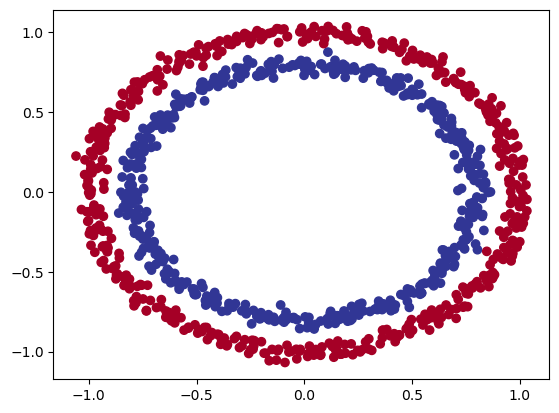

In [253]:
import matplotlib.pyplot as plt

# Visualize data 
plt.scatter(x=circles['x'],
            y=circles['y'],
            c=circles['label'],
            cmap=plt.cm.RdYlBu)

Looking at the shapes of the data X and y, we can determine that the shapes of X is 2 featured (vector) data and y is single feature (scalar) data. From this we can determine that there are 2 input and 1 output.

Now that we have a visual representation of the data, we need to convert the array of data into tensors for processing with our NN model.

In [254]:
import torch

X = torch.from_numpy(X_arr).type(torch.float)
y = torch.from_numpy(y_arr).type(torch.float)

X.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

### 02.02 Train Test Split data

Now that we have a tensor of X features and y labels. We will need to do a test train split of the data. For this we will utilize the `train_test_split` method provided by Scikit-Learn.

In [255]:
from sklearn.model_selection import train_test_split

test_size = 0.2                             # split the data into 80% train, 20% test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=42)

## 03. Build a Model

### 03.01 Setting up Helper Functions for Model

### 03.02 Setting up HyperParameters

This section use and definations for understanding what is going on is done later in writing the model class section

#### Linear Circle Model

In [256]:
# Hyperparameters Definations

# Linear Layer 1
in_features_1 = 2                   # in features for layer 1
out_features_1 = 5                  # out features for layer 1

# Linear Layer 2
in_features_2 = out_features_1      # in features for layer 2
out_features_2 = 1                  # out features for layer 2

lr = 0.1                            # learning rate

#### Non Lineear regression Classification model

In [257]:
# Hyperparameters Definations for non linear regression classification model

# Layer 1
in_feat_non_1 = 2
out_feat_non_1 = 8

# Layer 2
in_feat_non_2 = out_feat_non_1
out_feat_non_2 = 8

# Layer 3
in_feat_non_3 = out_feat_non_2
out_feat_non_3 = 1

lr_non = 0.1                            # learning rate

### 03.03 Writing the model Class

We'll want a model capable of handling our `X` data as inputs and producing something in the shape of our `y` data as outputs.

In other words, given `X` (features) we want our model to predict `y` (label).

This setup where you have features and labels is referred to as **supervised learning**. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of `X` and `y`.

Remember how I said input and output shapes are important? Here we'll see why.

Let's create a model class that:
1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`. 

#### Linear Regression Circle Model 

In [258]:
import torch
from torch import nn

# A 2 layerd linear regression model for testing on classification problem in the 2 circle dataset
class LinearRegressionCircleModelV1(nn.Module):
    def __init__(self):
        super.__init__(self)
        # create two linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)     # takes 2 features as input and produces 5 features as output
        self.layer_2 = nn.Linear(in_features=5, out_features=1)     # takes 5 features as input and produces 1 feature as output
        # NOTE: the out of the first layer is fed into the second layer so the out features and in features should match
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))                        # computation goes throuhg layer 1 then it's output to layer 2


What's going on here?

We've seen a few of these steps before.

The only major change is what's happening between `self.layer_1` and `self.layer_2`.

`self.layer_1` takes 2 input features `in_features=2` and produces 5 output features `out_features=5`.

This is known as having 5 **hidden units** or **neurons**.

This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, *potentially* leading to better outputs.

I say potentially because sometimes it doesn't work.

The number of hidden units you can use in neural network layers is a **hyperparameter** (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with. 

Since our dataset is small and simple, we'll keep it small.

The only rule with hidden units is that the next layer, in our case, `self.layer_2` has to take the same `in_features` as the previous layer `out_features`.

That's why `self.layer_2` has `in_features=5`, it takes the `out_features=5` from `self.layer_1` and performs a linear computation on them, turning them into `out_features=1` (the same shape as `y`).

*A visual example of what a similar classification neural network to the one we've just built looks like. Try creating one of your own on the [TensorFlow Playground website](https://playground.tensorflow.org/).*

You can also do the same as above using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [259]:
# Replication of above model using nn.Sequential
model_0 = nn.Sequential(                        # making a sequential model that will pass data through 2 linear regression model
    nn.Linear(
        in_features=in_features_1,              # setting up hyperparameter for linear model with 2 in features
        out_features=out_features_1             # setting up hyperparameter for linear model with 5 out features
    ),                                          # default bias is True
    nn.Linear(
        in_features=in_features_2,              # setting up hyperparameter for linear model with 5 in features
        out_features=out_features_2             # setting up hyperparameter for linear model with 1 out feature
    )                                           # default bias is True
).to(device)                                    # moving data to selected device

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.

In [260]:
# Make predictions with the model
model_0.eval()
with torch.inference_mode():
    untrained_logits = model_0(X_test.to(device))[:10]
print(f"Length of predictions: {len(untrained_logits)}, Shape: {untrained_logits.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_logits[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 10, Shape: torch.Size([10, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='mps:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Since out model has not been trained these output are basically random numbers.
They're the output of our `forward()` method.

Which implements two layers of `nn.Linear()` which internally calls the following equation:

$$
\mathbf{y} = x \cdot \mathbf{Weights}^T  + \mathbf{bias}
$$

The *raw outputs* (unmodified) of this equation ($y$) and in turn, the raw outputs of our model are often referred to as [**logits**](https://datascience.stackexchange.com/a/31045).

That's what our model is outputing above when it takes in the input data ($x$ in the equation or `X_test` in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the [sigmoid activation function](https://pytorch.org/docs/stable/generated/torch.sigmoid.html).

Let's try it out.

In [261]:
untrained_pred_probs = torch.sigmoid(untrained_logits)

untrained_pred_probs.shape

torch.Size([10, 1])

Now the output seems more consistent even if they are still random. Now they are in a form of **pridiction probabilities** ie they are how much the model things the data is in one class or other.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

- If y_pred_probs >= 0.5, y=1 (class 1)
- If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [262]:
# Find the predicted labels (round the prediction probabilities)
untrained_preds = torch.round(untrained_pred_probs)

# In full
untrained_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:10]))

# Check for equality
print(torch.eq(untrained_preds.squeeze(), untrained_pred_labels.squeeze()))

# Get rid of extra dimension
untrained_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True],
       device='mps:0')


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='mps:0')

#### Non linear regression Classification model

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

What do you think will happen when we introduce the capability for our model to use **non-linear activation functions**?

Well let's see.

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similar but different things. 

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (rectified linear-unit, [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

In [263]:
import torch
from torch import nn

class NonLinearCircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=in_feat_non_1, out_features=out_feat_non_1)
        self.layer_2 = nn.Linear(in_features=in_feat_non_2, out_features=out_feat_non_2)
        self.layer_3 = nn.Linear(in_features=in_feat_non_3, out_features=out_feat_non_3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [264]:
model_non = NonLinearCircleModelV1()

## 04. Training

### 04.00 Setting up helper methods for training

In [265]:
import torch
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """
        Calculates accuracy between truth labels and predictions.

        Args:
            y_true (torch.Tensor): Truth labels for predictions.
            y_pred (torch.Tensor): Predictions to be compared to predictions.

        Returns:
            [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model: torch.nn.Module,
                  X: torch.Tensor,
                  y: torch.Tensor,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  device: torch.device = device) -> tuple:
    """
        Training step for a model. 

        Args:
            model (torch.nn.Module): Model to train. 
            x (torch.Tensor): Input Features. 
            y (torch.Tensor): Target Labels. 
            loss_fn (torch.nn.Module): Loss Function to use for training. 
            optimizer (torch.optim.Optimizer): Optimizer to use for training. 
            device (torch.device, optional): Device to train on. Defaults to device.
        
        Returns:
            (torch.float, torch.float): Training Loss and Accuracy tuple. 
    """
    
    # train_loss, train_acc = 0.0, 0.0
    # Move model and data to device
    model.to(device)
    X, y = X.to(device), y.to(device)

    model.train()                                       # Set model to training mode
    logits = model(X).squeeze(1)                        # Forward Pass and Squeeze to remove extra 1 dimention
    pred = torch.round(torch.sigmoid(logits))           # Apply sigmoid to get probability and round to get predictions
    
    train_loss = loss_fn(logits,y)                      # Calculate loss, as we use BCEWithLogitsLoss we use logits insted of pred
    train_acc = accuracy_fn(y_true=y, y_pred=pred)      # Calculate accuracy

    optimizer.zero_grad()                               # Clear gradients from previous iteration

    train_loss.backward()                               # Back propogation

    optimizer.step()                                    # Gradient Decent, update weights

    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              X: torch.Tensor,
              y: torch.Tensor,
              loss_fn: torch.nn.Module,
              device: torch.device = device) -> tuple:
    """
        Make predictions on a test set and calculate accuracy

        Args:
            model (torch.nn.Module): Model to train. 
            X (torch.Tensor): Input Features. 
            y (torch.Tensor): Target Labels. 
            loss_fn (torch.nn.Module): Loss Function to use for training.
            device (torch.device, optional): Device to train on. Defaults to device.
        Returns:
            (torch.float, torch.float): Testing Loss and Accuracy tuple. 
    """
    test_loss, test_acc = 0.0, 0.0
    # move model and daa to device
    model.to(device)
    X, y = X.to(device), y.to(device)

    model.eval()                                            # Set model to evaluation mode
    with torch.inference_mode():                            # Disable gradient calculation for performance reasons
        logits = model(X).squeeze(1)                        # Make Prediction using the trained model
        pred = torch.round(torch.sigmoid(logits))           # Apply sigmoid to get probability and round to get predictions

        test_loss = loss_fn(logits,y)                       # Calculate loss, as we use BCEWithLogitsLoss we use logits insted of pred
        test_acc = accuracy_fn(y_true=y, y_pred=pred)       # Calculate accuracy
    
    return test_loss, test_acc


### 04.01 Setting up Loss Function and Optimizer

Different problem types require different loss functions. 

For example, for a regression problem (predicting a number) you might use mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, and the same applies to the Adam optimizer (`torch.optim.Adam()`). 

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Multi-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

*Table of various loss functions and optimizers, there are more but these are some common ones you'll see.*

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

> **Note:** Recall a **loss function** is what measures how *wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

Which one should you use? 

The [documentation for `torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer. 

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer. 

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4). It can be confusing at first but as with many things, it becomes easier with practice.

In [266]:
# Create a Loss function
# loss_fn_0 = nn.BCELoss()                         # BCELoss = no sigmoid built-in
loss_fn_0 = nn.BCEWithLogitsLoss()                # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer_0 = torch.optim.SGD(params=model_0.parameters(),  # model 0 parameters
                              lr=lr)                        # learning rate defined 0.1 in hyperparameter section


# loss and optimizer for Non Linear Circle Model V1
loss_fn_non = nn.BCEWithLogitsLoss()
optimizer_non = torch.optim.SGD(params=model_non.parameters(),
                                lr=lr_non)

### 04.02 Training Model

Okay, now we've got a loss function and optimizer ready to go, let's train a model.

Steps in training:

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>



#### Training Linear Regression Model

In [267]:
from timeit import default_timer as timer
from tqdm.auto import tqdm                          # Import tqdm for progress bar

torch.manual_seed(42)

#measure Time
timer_start_time = timer()
epochs = 500
results_1 = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }

for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss, train_acc = train_step(model=model_0,
                                       X=X_train,
                                       y=y_train,
                                       loss_fn=loss_fn_0,
                                       optimizer=optimizer_0,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model_0,
                                    X=X_test,
                                    y=y_test,
                                    loss_fn=loss_fn_0,
                                    device=device)
    
    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}\n---------")
        print(f"Training Loss: {train_loss:.5f} | Train Acc:{train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc:{test_acc:.2f}%")
    results_1["train_loss"].append(train_loss.cpu().detach().numpy())
    results_1['train_acc'].append(train_acc)
    results_1["test_loss"].append(test_loss.cpu().detach().numpy())
    results_1["test_acc"].append(test_acc)

timer_end_time = timer()

total_training_time_model_0 = print_train_time(start=timer_start_time,
                                               end=timer_end_time,
                                               device=device)

Epochs:   4%|▍         | 22/500 [00:00<00:04, 107.02it/s]

Epoch: 0
---------
Training Loss: 0.69569 | Train Acc:50.00% | Test Loss: 0.69721 | Test Acc:50.00%


Epochs:  26%|██▌       | 128/500 [00:00<00:02, 144.83it/s]

Epoch: 100
---------
Training Loss: 0.69302 | Train Acc:50.50% | Test Loss: 0.69542 | Test Acc:46.50%


Epochs:  42%|████▏     | 209/500 [00:01<00:01, 152.66it/s]

Epoch: 200
---------
Training Loss: 0.69299 | Train Acc:51.50% | Test Loss: 0.69503 | Test Acc:46.50%


Epochs:  64%|██████▍   | 322/500 [00:02<00:01, 138.51it/s]

Epoch: 300
---------
Training Loss: 0.69298 | Train Acc:51.25% | Test Loss: 0.69485 | Test Acc:45.50%


Epochs:  84%|████████▍ | 421/500 [00:03<00:00, 176.90it/s]

Epoch: 400
---------
Training Loss: 0.69298 | Train Acc:51.12% | Test Loss: 0.69476 | Test Acc:45.50%


Epochs: 100%|██████████| 500/500 [00:03<00:00, 143.22it/s]

Train time on mps: 3.495 seconds


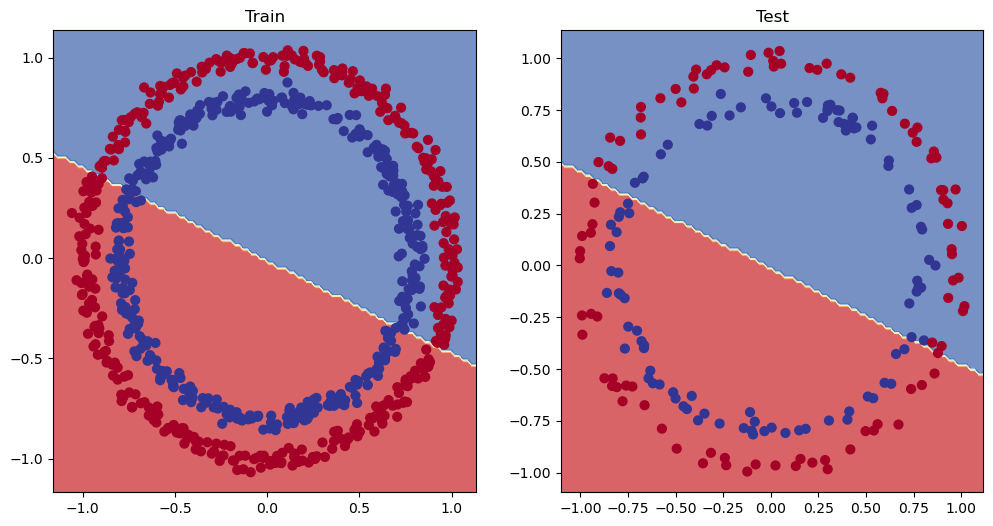

In [268]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_0, X=X_test, y=y_test)

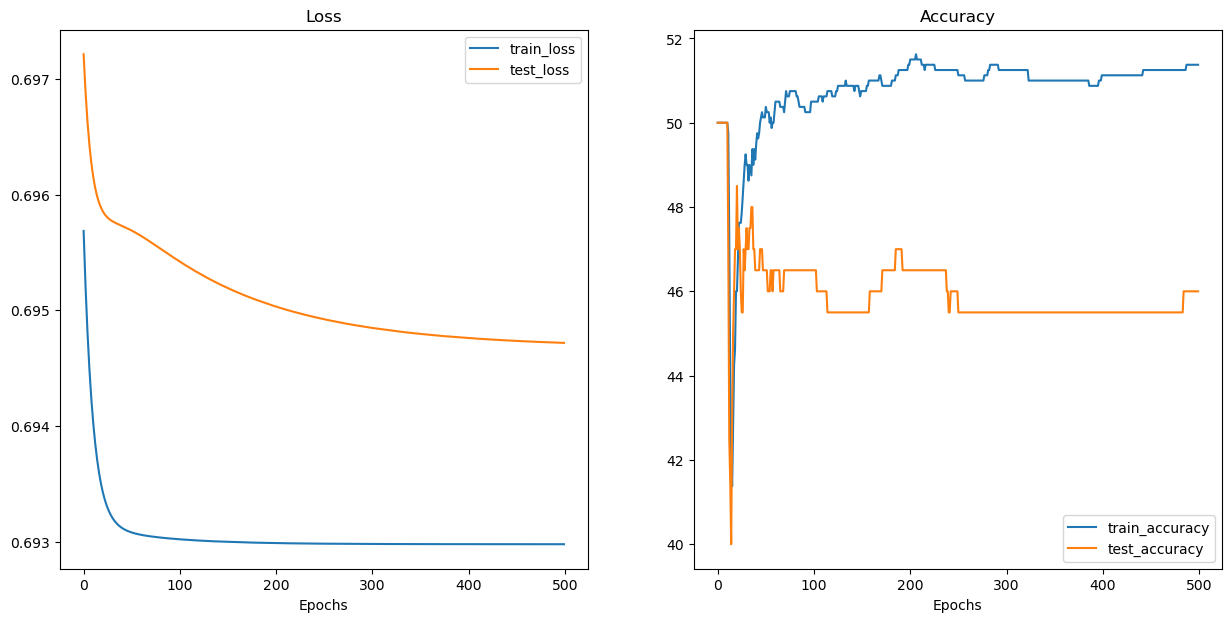

In [269]:
plot_loss_curves(results=results_1)

As we see here the training and test accuracy are close to 50%. As we have 1000 data for each class of the circle 0 and 1. It seems it is closer to the probability of blindly gussing a number between 0 and 1.

From the decision boundary plot we see the model is trying to seperate the data points of class 0 and 1 by a straight line. But the data points are not linearly seperable. Let us verify this observation to check if even out model is able to learn anything at all or is the model itself is the problem. As from our observation it can draw a line then can it predict a line ?

Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

 24%|██▎       | 118/500 [00:00<00:00, 577.24it/s]

Epoch: 0
---------
Training Loss: 0.69298 | Test Loss: 0.69472 
Epoch: 100
---------
Training Loss: 0.69298 | Test Loss: 0.69472 


 61%|██████    | 303/500 [00:00<00:00, 576.03it/s]

Epoch: 200
---------
Training Loss: 0.69298 | Test Loss: 0.69472 
Epoch: 300
---------
Training Loss: 0.69298 | Test Loss: 0.69472 


 94%|█████████▍| 471/500 [00:00<00:00, 529.47it/s]

Epoch: 400
---------
Training Loss: 0.69298 | Test Loss: 0.69472 


100%|██████████| 500/500 [00:01<00:00, 476.09it/s]


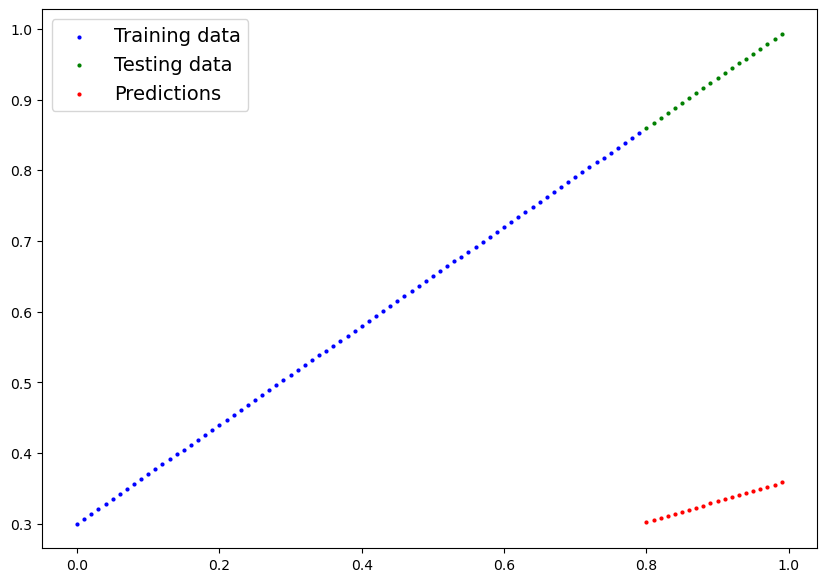

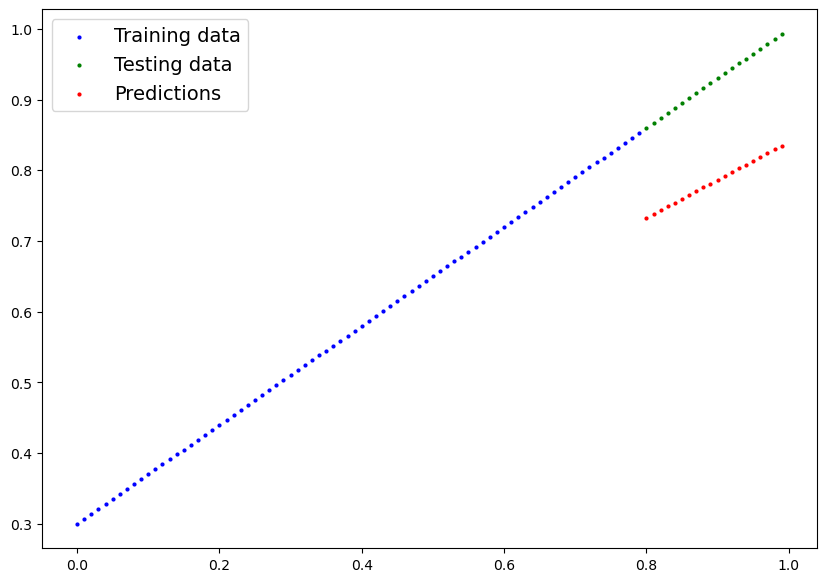

In [270]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# make a model similar to before with difference being we only have 1 feature and 1 label 
model_1 = nn.Sequential(
    nn.Linear(in_features=1,out_features=5),
    nn.Linear(in_features=5,out_features=1),
)

# make untrained prediction to compare later
model_1.eval()
with torch.inference_mode():
    untrained_preds = model_1(X_test_regression)

# move model and data to device
model_1.to(device)

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Define loss function and optimizer
loss_fn_1 = nn.L1Loss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=lr)

# seed random
torch.manual_seed(42)

epochs = 500

# training the model
for epoch in tqdm(range(epochs)):
    model_1.train()

    y_train_pred = model_1(X_train_regression)                      # Forward pass
    training_loss = loss_fn_1(y_train_pred, y_train_regression)     # Calculate loss
    
    optimizer_1.zero_grad()                                         # optimizer zero grad
    training_loss.backward()                                        # forward pass
    optimizer_1.step()                                              # step

    # testing
    model_1.eval()
    with torch.inference_mode():
        y_test_pred = model_1(X_test_regression)
        testing_loss = loss_fn_1(y_test_pred,y_test_regression)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}\n---------")
        print(f"Training Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} ")


# make prediction from trained model 
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test_regression)

# plot pre training prediction
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=untrained_preds)
# plot post training prediction
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())


So out model here is doing far more than just random guessing points in the line. This is good as we know our model has the capacity to learn. 

> **Note:** A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up. 
>
> This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then **overfitting** (making the model perform too well) on that small example before increasing the amount of data or the model size/design to *reduce* overfitting.

Now however we can draw a conclusion that for the kind of data and that we are working on and the problem we need to solve, simple linear model does not work. All it can do is draw a straight line. But for our problem and dataset character we need to draw a non straight(non-linear) line.

#### Training Non Linernear Classification model

In [271]:
from timeit import default_timer as timer
from tqdm.auto import tqdm                          # Import tqdm for progress bar

torch.manual_seed(42)

#measure Time
timer_start_time = timer()
epochs = 1000
results_non = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }

for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss, train_acc = train_step(model=model_non,
                                       X=X_train,
                                       y=y_train,
                                       loss_fn=loss_fn_non,
                                       optimizer=optimizer_non,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model_non,
                                    X=X_test,
                                    y=y_test,
                                    loss_fn=loss_fn_non,
                                    device=device)
    
    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}\n---------")
        print(f"Training Loss: {train_loss:.5f} | Train Acc:{train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc:{test_acc:.2f}%")
    results_non["train_loss"].append(train_loss.cpu().detach().numpy())
    results_non['train_acc'].append(train_acc)
    results_non["test_loss"].append(test_loss.cpu().detach().numpy())
    results_non["test_acc"].append(test_acc)

timer_end_time = timer()

total_training_time_model_non = print_train_time(start=timer_start_time,
                                               end=timer_end_time,
                                               device=device)

Epochs:   1%|          | 10/1000 [00:00<00:10, 96.19it/s]

Epoch: 0
---------
Training Loss: 0.70233 | Train Acc:50.00% | Test Loss: 0.70139 | Test Acc:50.00%


Epochs:  12%|█▏        | 122/1000 [00:01<00:09, 94.09it/s]

Epoch: 100
---------
Training Loss: 0.69174 | Train Acc:49.88% | Test Loss: 0.69132 | Test Acc:45.50%


Epochs:  21%|██        | 212/1000 [00:02<00:07, 110.17it/s]

Epoch: 200
---------
Training Loss: 0.69109 | Train Acc:51.38% | Test Loss: 0.69037 | Test Acc:53.50%


Epochs:  34%|███▍      | 338/1000 [00:03<00:04, 156.58it/s]

Epoch: 300
---------
Training Loss: 0.69035 | Train Acc:51.38% | Test Loss: 0.68929 | Test Acc:55.50%


Epochs:  43%|████▎     | 432/1000 [00:04<00:04, 132.09it/s]

Epoch: 400
---------
Training Loss: 0.68946 | Train Acc:51.50% | Test Loss: 0.68810 | Test Acc:56.50%


Epochs:  52%|█████▏    | 519/1000 [00:04<00:03, 138.92it/s]

Epoch: 500
---------
Training Loss: 0.68839 | Train Acc:51.88% | Test Loss: 0.68679 | Test Acc:56.50%


Epochs:  63%|██████▎   | 626/1000 [00:05<00:02, 154.99it/s]

Epoch: 600
---------
Training Loss: 0.68705 | Train Acc:52.00% | Test Loss: 0.68526 | Test Acc:56.50%


Epochs:  70%|███████   | 701/1000 [00:05<00:01, 165.72it/s]

Epoch: 700
---------
Training Loss: 0.68535 | Train Acc:52.25% | Test Loss: 0.68358 | Test Acc:56.00%


Epochs:  83%|████████▎ | 827/1000 [00:06<00:01, 158.48it/s]

Epoch: 800
---------
Training Loss: 0.68318 | Train Acc:52.75% | Test Loss: 0.68150 | Test Acc:55.50%


Epochs:  94%|█████████▎| 936/1000 [00:07<00:00, 168.66it/s]

Epoch: 900
---------
Training Loss: 0.68036 | Train Acc:64.75% | Test Loss: 0.67902 | Test Acc:63.50%


Epochs: 100%|██████████| 1000/1000 [00:07<00:00, 125.16it/s]

Train time on mps: 7.996 seconds


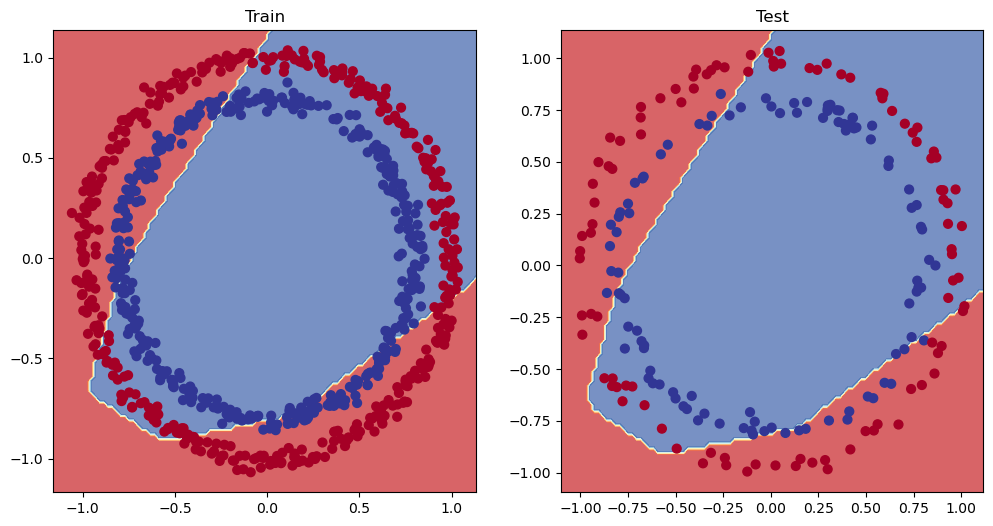

In [274]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_non, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_non, X=X_test, y=y_test)

This seems much better at fitting the data than the previous linear model. Let us compare the 2 models test prediction side by side.

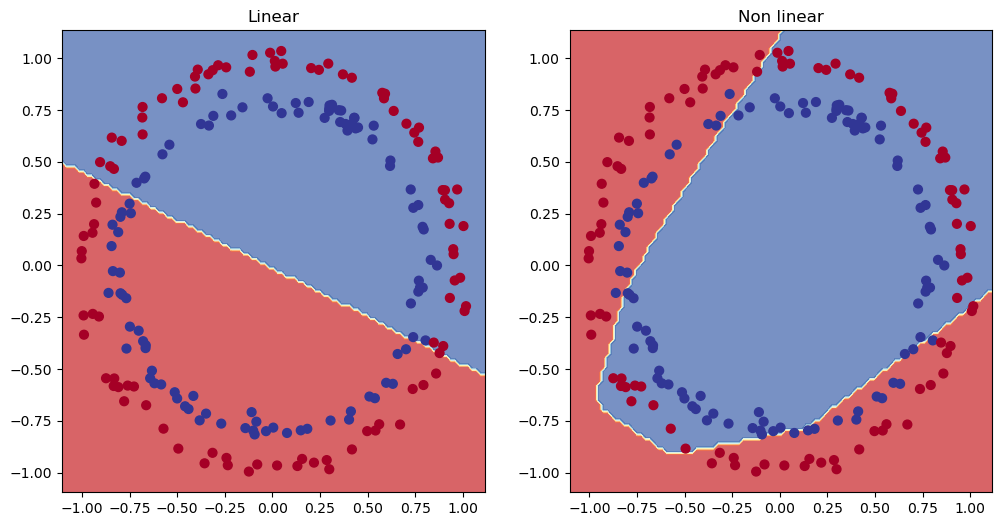

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Linear")
plot_decision_boundary(model=model_1, X=X_test, y=y_test)
plt.subplot(1, 2, 2)
plt.title("Non linear")
plot_decision_boundary(model=model_non, X=X_test, y=y_test)

We saw before how adding non-linear activation functions to our model can help it to model non-linear data.

> **Note:** Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns). 

Now there's plenty more [non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that exist in PyTorch that we haven't tried.

But these ReLU and Sigmoid are two of the most common.

The point remains, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines, almost anything. That's exactly what our model is doing when we combine linear and non-linear functions. Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data. And those tools are linear and non-linear functions.

## 05. Storing & Loading Model

### 05.01 Saving Model state to file

In [ ]:
from pathlib import Path
MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_0_NAME = "001_LinearRegressionClassificationModel.pth"
MODEL_0_SAVE_PATH = MODEL_PATH / MODEL_0_NAME

MODEL_1_NAME = "001_NonLinearRegressionClassificationModel.pth"
MODEL_1_SAVE_PATH = MODEL_PATH / MODEL_1_NAME

print(f"Saving model LinearRegressionClassificationModel to : {MODEL_0_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_0_SAVE_PATH)
print("Done")

print(f"Saving model NonLinearRegressionClassificationModel to : {MODEL_1_SAVE_PATH}")
torch.save(obj=model_non.state_dict(),
           f=MODEL_1_SAVE_PATH)
print("Done")

### 05.02 Loading Model state from file

In [ ]:
loaded_model = NonLinearCircleModelV1()                 # Create an instance of the model
loaded_model.load_state_dict(torch.load(f=MODEL_1_SAVE_PATH)) # Load the saved state dict

loaded_model.to(device)

### 05.03 Testing loaded model

In [ ]:
# make prediction from loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

#make prediction from old model
model_0.eval()
with torch.inference_mode():
  model_non_preds = model_non(X_test)

torch.eq(loaded_model_preds, model_non_preds).all()               # check if predictions are the same

## 06. Conclusion

In this example we utilized linear and non linear models for a classification problem. We compared the training between two types of models on a classification problem. We saw that the classification required was a Binary classification as there were 2 classes for a given input feature. We trained a liner model on our binary classification data and saw that the prediction made were close to the gussing probability of 50% as it's final performance. We also tested the trainability of our linear model utilizing a linear regression problem to determine if the model had the capacity to learn anything. We concluded that the model had capacity to train but the problem was with trying to train a wrong model type on the binary classification problem. We also saw that the model output behavour and the concept of logits, sigmoid activation function to convert logits into prediction probabilities and rounding the output to get the pridiction labels. 

We utilized BCELossWithLogits as our loss function and SGD as our optimizer to train both linear and non linear models. 

With that conclusion we moved on to a non linear model. In this example we utilized `nn.ReLU` activation function to introduce non linearity to our model. We then compared the prediction of both linear and non linear models side by side utilizing visual method of plotting decision boundaries of each models.